# Determine if a unit is providing marginal power

[Change in net ERCOT load](#Change-in-net-load)  
[Import and concat EPA hourly data](#EPA-data)  
[Group EPA hourly gen change by cluster](#Generation-change-by-group/cluster)  
**[To-do for finishing model inputs](#Other-data-we-still-need-in-this-DF!!!)**  

[A couple plots of individual power plants](#Plot-the-change-in-generation-for-plant-ids-298-&-3439)

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import cPickle as pickle

ImportError: No module named seaborn

## Method
For every hour, find the change in **net** load from the previous hour. Net load is defined as total load minus wind generation.

### Change in net load
Use ERCOT data on hourly load and hourly wind generation to create `Net Load` and `Net Change` columns.

In [88]:
filename = 'ERCOT wind data.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
ercot = pd.read_csv(fullpath, index_col=0)

In [89]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680


In [90]:
ercot.loc[:,'Net Load (MW)'] = ercot.loc[:,'ERCOT Load, MW'] - ercot.loc[:,'Total Wind Output, MW']

In [91]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW)
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9


In [92]:
ercot.loc[1:,'Net Load Change (MW)'] = ercot.iloc[1:,-1].values - ercot.iloc[:-1,-1].values

In [93]:
ercot.loc[:,'DATETIME'] = pd.to_datetime(ercot.index)

In [94]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),DATETIME
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007-01-01 00:00:00
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,2007-01-01 01:00:00
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,2007-01-01 02:00:00
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,2007-01-01 03:00:00
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,2007-01-01 04:00:00


### EPA data
Calculate the change in generation for each plant in every hour. By summing the change across all plants in a group (cluster), we will have the change in generation for that group from the previous hour to the current hour. 

In [8]:
# load a zipped pickle file 
# from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [9]:
filename = 'EPA hourly dictionary.pgz'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

epaDict = load_zipped_pickle(fullpath)

In [10]:
epaDict.keys()

['2012 Jan-June',
 '2007 July-Dec',
 '2013 Jan-June',
 '2008 July-Dec',
 '2011 Jan-June',
 '2010 Jan-June',
 '2010 July-Dec',
 '2009 July-Dec',
 '2015 Jan-June',
 '2015 July-Dec',
 '2012 July-Dec',
 '2007 Jan-June',
 '2008 Jan-June',
 '2011 July-Dec',
 '2014 Jan-June',
 '2014 July-Dec',
 '2009 Jan-June',
 '2013 July-Dec']

In [75]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        gen_change = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        temp.loc[:,'Gen Change (MW)'] = gen_change
        df_list.append(temp)
    return pd.concat(df_list)

In [76]:
allEPA = pd.concat(epaDict)

In [77]:
allEPA.fillna(0, inplace=True)
allEPA.head()

CO2 (SHORT TONS)  COUNTY       DATE            DATETIME  \
2007 Jan-June 0               0.0  Harris 2007-01-01 2007-01-01 00:00:00   
              1               0.0  Harris 2007-01-01 2007-01-01 01:00:00   
              2               0.0  Harris 2007-01-01 2007-01-01 02:00:00   
              3               0.0  Harris 2007-01-01 2007-01-01 03:00:00   
              4               0.0  Harris 2007-01-01 2007-01-01 04:00:00   

                 EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
2007 Jan-June 0           6            29.7239            -95.2258   
              1           6            29.7239            -95.2258   
              2           6            29.7239            -95.2258   
              3           6            29.7239            -95.2258   
              4           6            29.7239            -95.2258   

                          FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
2007 Jan-June 0  AES Western Power, LLC              0.0                 0.0   
              1  AES Western Power, LLC              0.0                 0.0   
              2  AES Western Power, LLC              0.0                 0.0   
              3  AES Western Power, LLC              0.0                 0.0   
              4  AES Western Power, LLC              0.0                 0.0   

                 HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
2007 Jan-June 0     0       ERCOT           0.0      3461           0.0    TX   
              1     1       ERCOT           0.0      3461           0.0    TX   
              2     2       ERCOT           0.0      3461           0.0    TX   
              3     3       ERCOT           0.0      3461           0.0    TX   
              4     4       ERCOT           0.0      3461           0.0    TX   

                 STEAM LOAD (1000LB/HR)  YEAR  
2007 Jan-June 0                     0.0  2007  
              1                     0.0  2007  
              2                     0.0  2007  
              3                     0.0  2007  
              4                     0.0  2007

In [78]:
allEPA = plant_gen_delta(allEPA)

In [79]:
allEPA.reset_index(drop=True, inplace=True)

In [80]:
allEPA.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change (MW)
4511875,395.801,Brazoria,2015-12-31,2015-12-31 19:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6660.4,19,ERCOT,174.4,55015,3.358,TX,0.0,2015,-1.0
4511876,397.101,Brazoria,2015-12-31,2015-12-31 20:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,423.0,6681.5,20,ERCOT,153.7,55015,3.378,TX,0.0,2015,1.0
4511877,395.601,Brazoria,2015-12-31,2015-12-31 21:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6655.3,21,ERCOT,162.9,55015,3.364,TX,0.0,2015,-3.0
4511878,401.501,Brazoria,2015-12-31,2015-12-31 22:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6756.3,22,ERCOT,175.4,55015,3.383,TX,0.0,2015,0.0
4511879,403.300,Brazoria,2015-12-31,2015-12-31 23:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6787.3,23,ERCOT,156.4,55015,3.402,TX,0.0,2015,2.0


## Generation change by group/cluster
Clusters are determined using k-means. 

In [17]:
cluster_df = pd.read_csv('Cluster labels.csv')

In [81]:
merged_epa_cluster = pd.merge(allEPA, cluster_df, left_on=['PLANT_ID', 'YEAR'], 
                             right_on=['plant_id', 'year'])

In [82]:
merged_epa_cluster.head()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),...,PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change (MW),Unnamed: 0,year,plant_id,cluster_id_6
0,0.0,Nueces,2007-01-01,2007-01-01 00:00:00,6,27.6067,-97.3119,Barney M. Davis,0.0,0.0,...,4939,0.0,TX,0.0,2007,NaN,57,2007,4939,4
1,0.0,Nueces,2007-01-01,2007-01-01 01:00:00,6,27.6067,-97.3119,Barney M. Davis,0.0,0.0,...,4939,0.0,TX,0.0,2007,0.0,57,2007,4939,4
2,0.0,Nueces,2007-01-01,2007-01-01 02:00:00,6,27.6067,-97.3119,Barney M. Davis,0.0,0.0,...,4939,0.0,TX,0.0,2007,0.0,57,2007,4939,4
3,0.0,Nueces,2007-01-01,2007-01-01 03:00:00,6,27.6067,-97.3119,Barney M. Davis,0.0,0.0,...,4939,0.0,TX,0.0,2007,0.0,57,2007,4939,4
4,0.0,Nueces,2007-01-01,2007-01-01 04:00:00,6,27.6067,-97.3119,Barney M. Davis,0.0,0.0,...,4939,0.0,TX,0.0,2007,0.0,57,2007,4939,4


In [83]:
grouped_clusters = merged_epa_cluster.loc[:,['Gen Change (MW)', 'GROSS LOAD (MW)', 'DATETIME', 'cluster_id_6']].groupby(['DATETIME', 'cluster_id_6']).sum()

In [84]:
grouped_clusters.reset_index(inplace=True)

In [85]:
grouped_clusters.dtypes

DATETIME           datetime64[ns]
cluster_id_6                int64
Gen Change (MW)           float64
GROSS LOAD (MW)           float64
dtype: object

In [95]:
grouped_clusters_ercot = pd.merge(grouped_clusters, ercot, on='DATETIME')

In [96]:
grouped_clusters_ercot.loc[:,'year'] = grouped_clusters_ercot.loc[:,'DATETIME'].apply(lambda x: x.year)
grouped_clusters_ercot.head()

,DATETIME,cluster_id_6,Gen Change (MW),GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),year
0,2007-01-01,0,NaN,4596.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007
1,2007-01-01,1,NaN,4614.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007
2,2007-01-01,2,NaN,124.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007
3,2007-01-01,3,NaN,126.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007
4,2007-01-01,4,NaN,537.0,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007


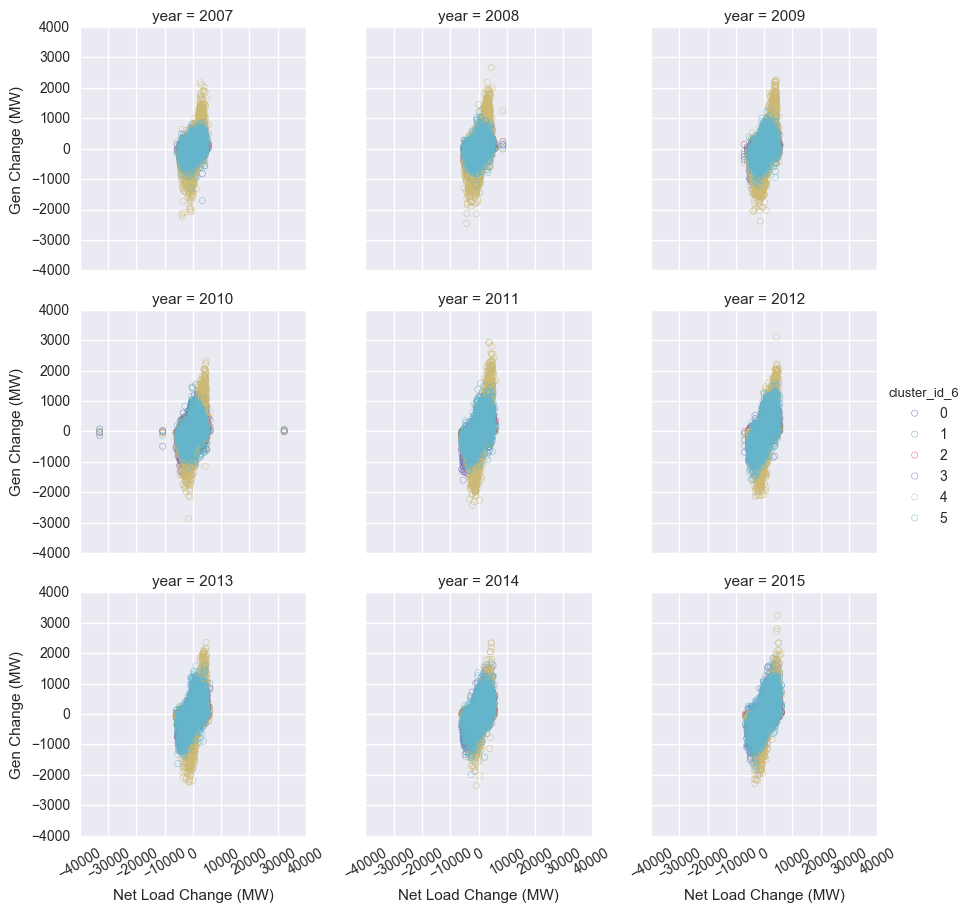

In [100]:
g = sns.FacetGrid(grouped_clusters_ercot, col='year', col_wrap=3, hue='cluster_id_6')
g.map(plt.scatter, 'Net Load Change (MW)', 'Gen Change (MW)', facecolors='None')
g.set_xticklabels(rotation=30)
g.add_legend()

Generally the figure below shows that each cluster tends to behave somewhat linearly (change in generation over the hour vs change in net load), but there are a couple exceptions.

- Cluster 4 looks like it might have 2 distinct groups in it. See if this is still true after we go back and check all calculations.
- Same for Cluster 3, but not as strong of an effect.

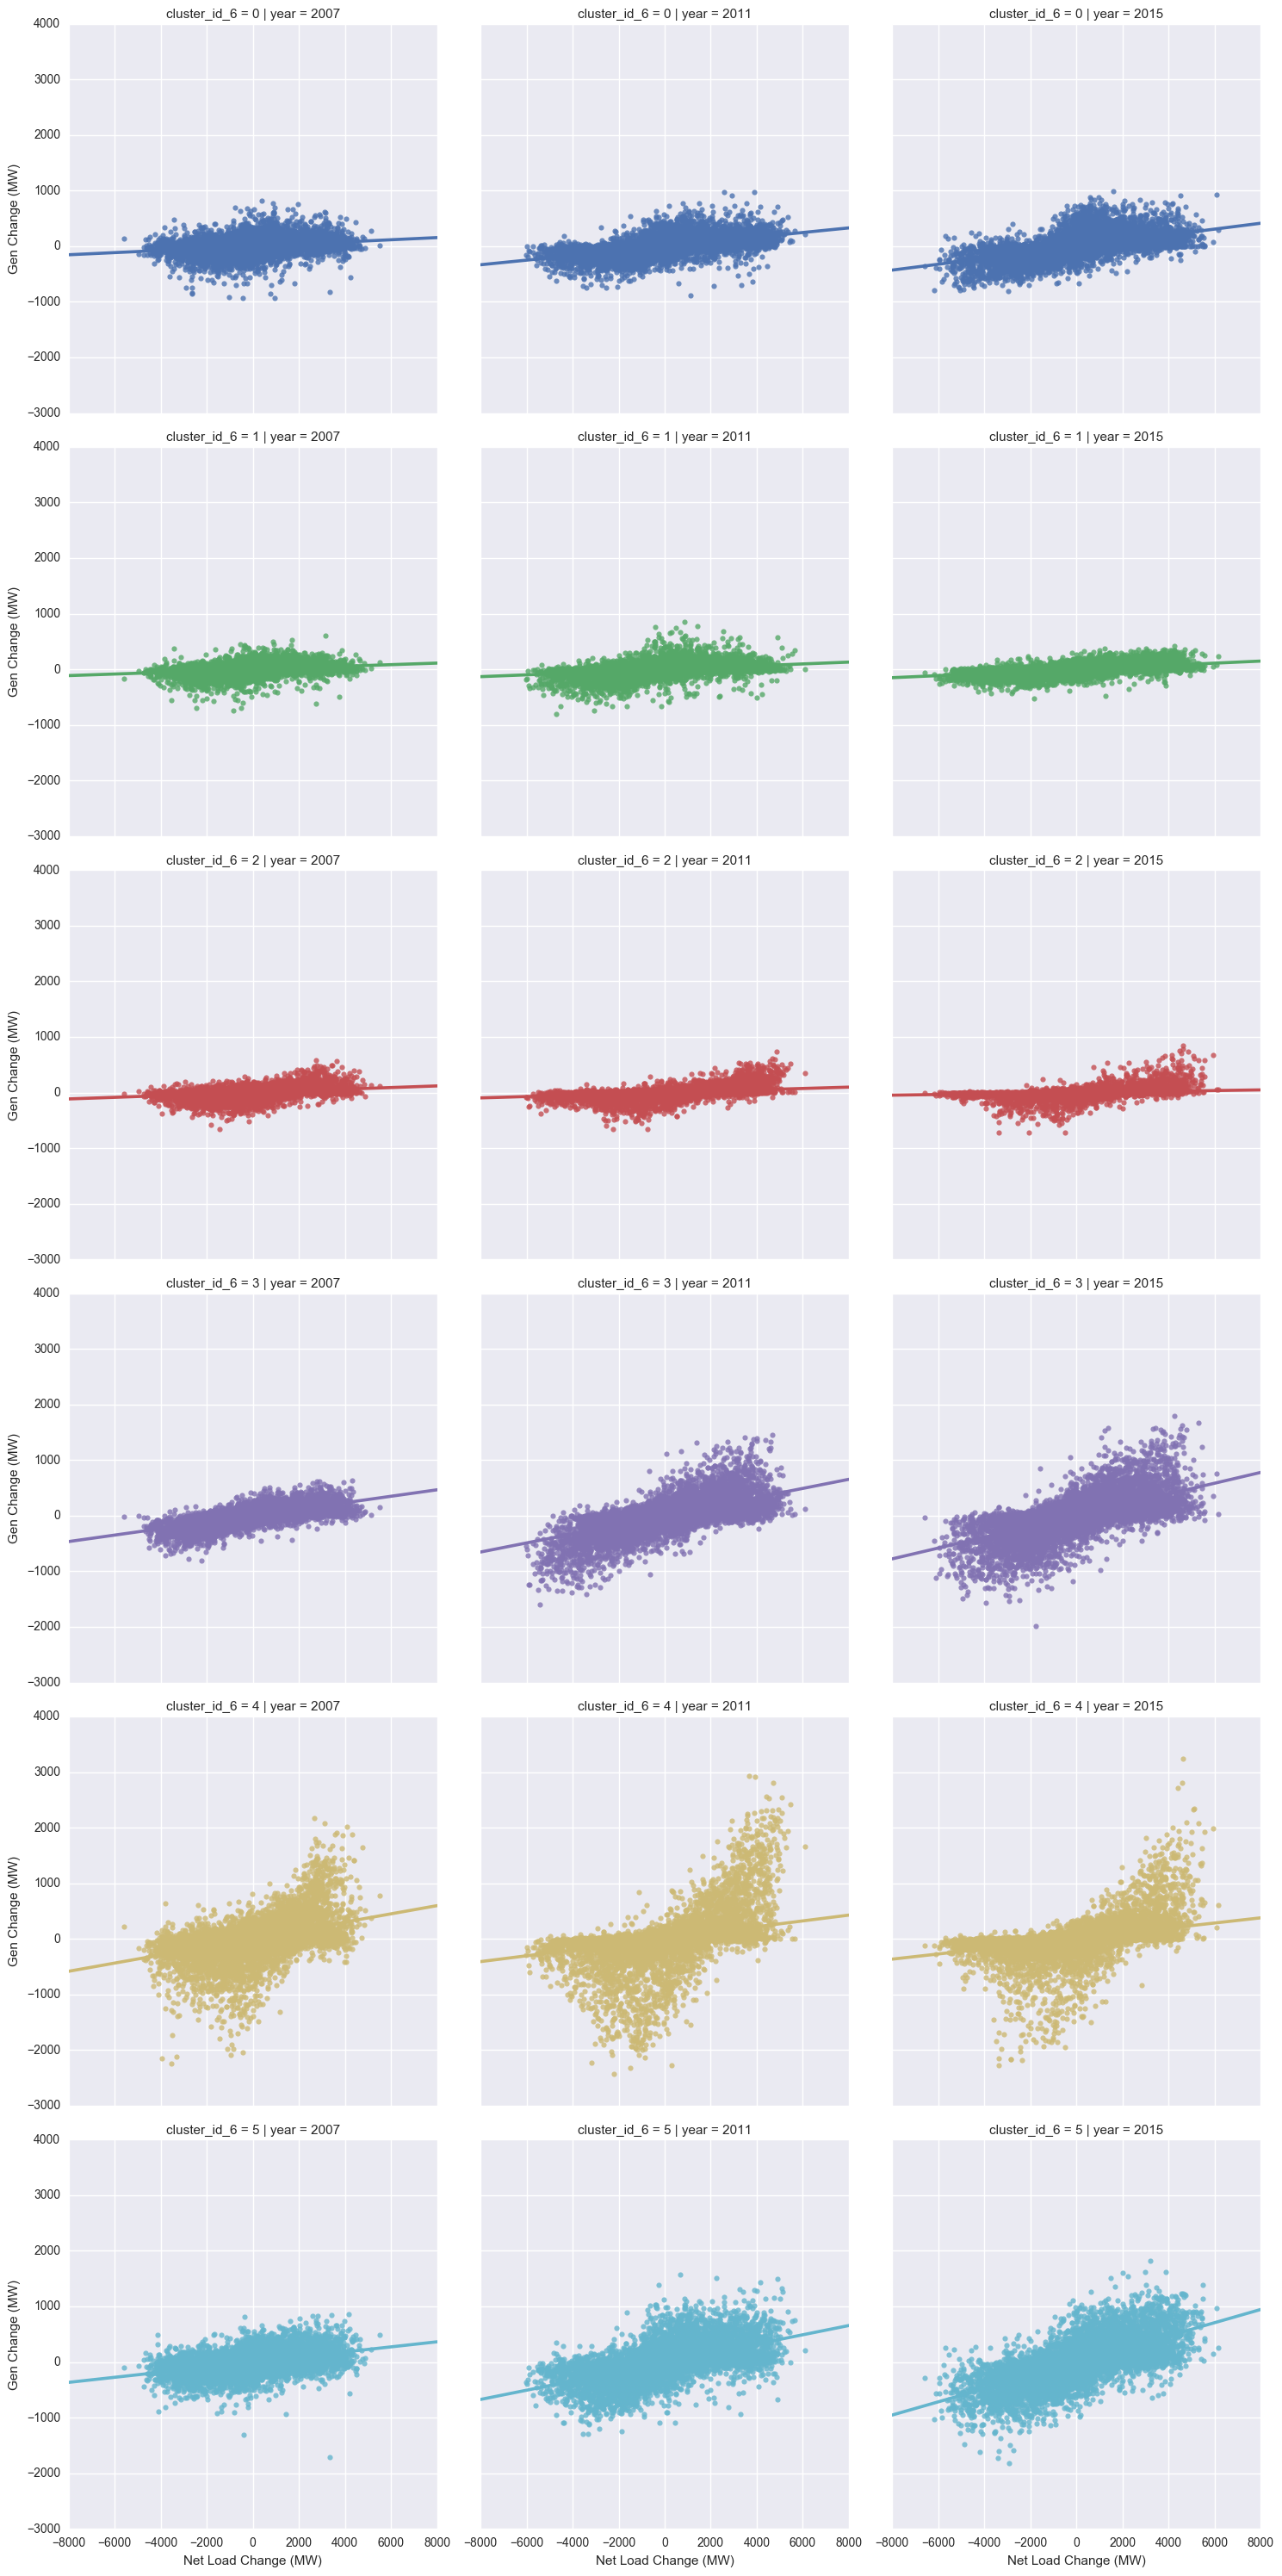

In [109]:
sns.lmplot('Net Load Change (MW)', 'Gen Change (MW)', data=filtered_data,
           col='year', row='cluster_id_6', hue='cluster_id_6', robust=True, ci=None)

The figure below shows how/if ramping changes as wind generation increases from 2007 to 2015. Cluster 3 is especially interesting, because it contains high-efficiency NG plants with average capacity just under 1 GW. Over time it starts ramping up (and down) by larger amounts . Some other clusters show similar behavior, while other (like 0, 1, 2) don't change nearly as much.

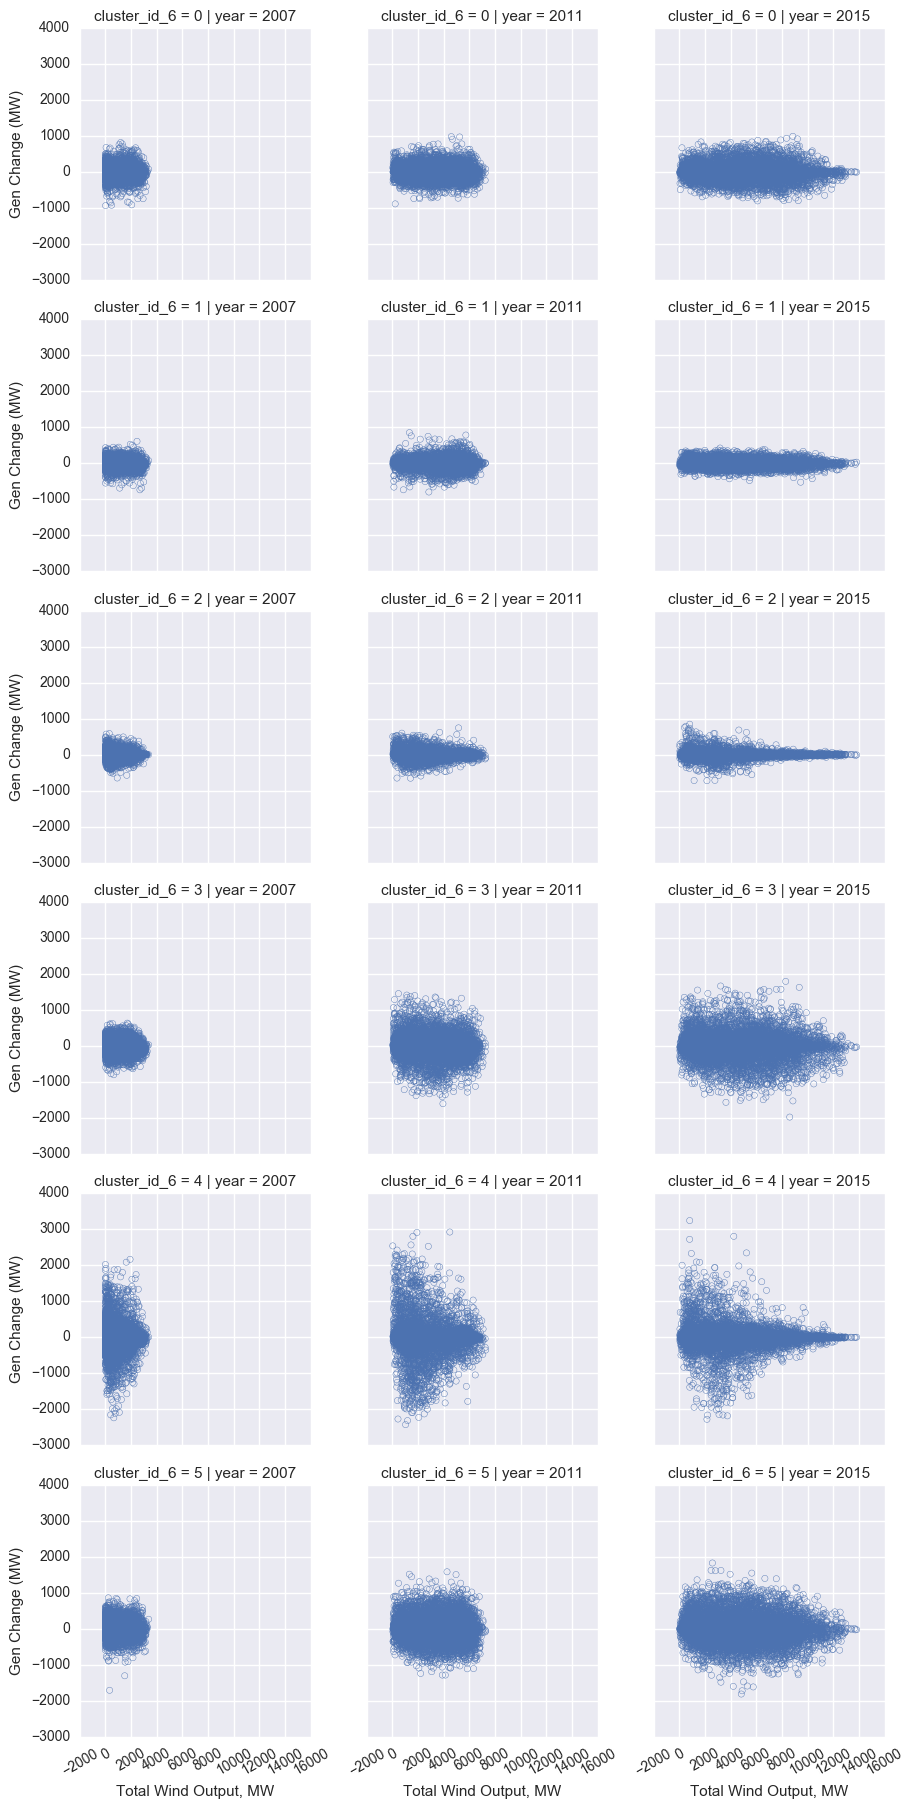

In [102]:
filtered_data = grouped_clusters_ercot.loc[grouped_clusters_ercot['year'].isin([2007, 2011, 2015])]

g = sns.FacetGrid(filtered_data, col='year', row='cluster_id_6')
g.map(plt.scatter, 'Total Wind Output, MW', 'Gen Change (MW)', facecolors='None')
g.set_xticklabels(rotation=30)
g.add_legend()

### Getting Total Capacity per Cluster

In [ ]:
#Load EIA 860 from picle
eia860fname = "EIA 860.pkl"
eia860Full = os.path.join(path, eia860fname)
eia860Dict = pickle.load(open(eia860Full, "rb"))

#Add year to as a column
for k in eia860Dict.keys():
    eia860Dict[k]["Year"] = k

#Flatten dictionary, rename columns, and do inner join 
merged860 = pd.concat(eia860Dict)
merged860.columns = ["plant_id", "nameplate_capacity", "year"]
merged860 = cluster_df.merge(merged860, on=["plant_id", "year"])

groupCapacity = merged860.loc[:,["cluster_id_6", "year", "nameplate_capacity"]].groupby(by=["cluster_id_6", "year"]).sum()




### Other data we still need in this DF!!!
Still need the total capacity of each cluster at that hour (determined by year).

Anything else?

X (for every cluster and every hour):
- Total installed wind
- Total wind generation
- Change in net demand (demand change + wind change) from previous hour
- Total capacity of the cluster
- Current generation of the cluster
- Natural gas price (monthly)
- Coal price (quarterly, data is not in format I hoped for)
    - We either need to use a price for "All coal" (both SUB and LIG), or figure out the % heat input for each cluster. I'm fine either leaving out coal price to start or just using "All coal".

If we have time and need to improve performance, maybe add change in cluster generation over earlier timesteps (e.g. from two hours ago to one hour ago).

y (for every cluster and every hour)
- Change in cluster generation from previous hour

### Export EPA with change in generation
**Don't think we need this anymore**

In [ ]:
filename = 'EPA with hourly gen change.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
allEPA.to_csv(fullpath)

In early years the generation change is almost independent of the demand change. This slowly shifts over time, so that the generation is correlated with 

### Plot the change in generation for plant ids 298 & 3439

In [98]:
plants = allEPA.loc[allEPA['PLANT_ID'].isin([298, 3439]),:]

In [99]:
plants.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change (MW)
1617163,1504.3,Limestone,2015-12-31,2015-12-31 19:00:00,6,31.4219,-96.2525,Limestone,1552.0,13816.9,19,ERCOT,2418.4,298,5165.4,TX,0.0,2015,-39.0
1617164,1080.6,Limestone,2015-12-31,2015-12-31 20:00:00,6,31.4219,-96.2525,Limestone,1103.0,9925.9,20,ERCOT,1746.0,298,3614.5,TX,0.0,2015,-449.0
1617165,904.5,Limestone,2015-12-31,2015-12-31 21:00:00,6,31.4219,-96.2525,Limestone,903.0,8308.0,21,ERCOT,1690.4,298,2987.5,TX,0.0,2015,-200.0
1617166,913.6,Limestone,2015-12-31,2015-12-31 22:00:00,6,31.4219,-96.2525,Limestone,902.0,8391.6,22,ERCOT,1644.1,298,3046.2,TX,0.0,2015,-1.0
1617167,916.4,Limestone,2015-12-31,2015-12-31 23:00:00,6,31.4219,-96.2525,Limestone,901.0,8417.2,23,ERCOT,1575.6,298,3145.4,TX,0.0,2015,-1.0


In [32]:
plants.index = plants['DATETIME']

In [38]:
test = pd.merge(ercot, plants, left_index=True, right_index=True)

In early years the generation change is almost independent of the demand change. This slowly shifts over time, so that the generation is correlated with 

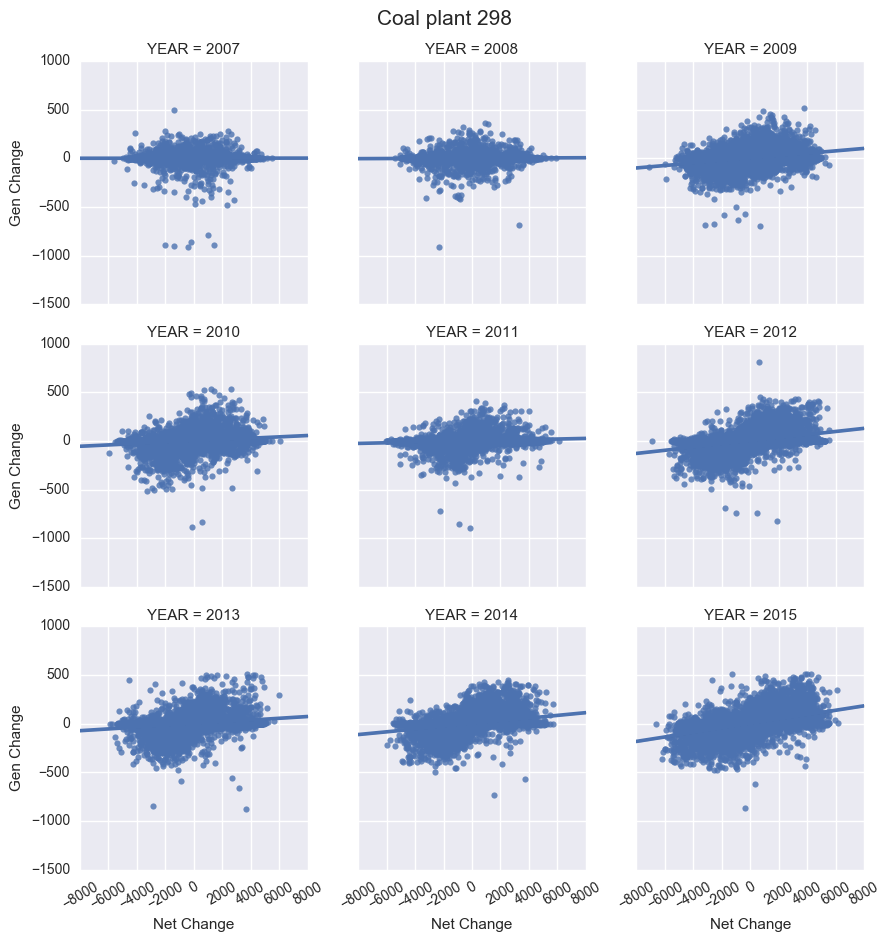

In [40]:
g = sns.FacetGrid(test[test['PLANT_ID']==298], col='YEAR', col_wrap=3)
g.map(sns.regplot, 'Net Change', 'Gen Change')
g.set_xticklabels(rotation=30)
plt.suptitle('Coal plant 298', y=1.02, size=15)

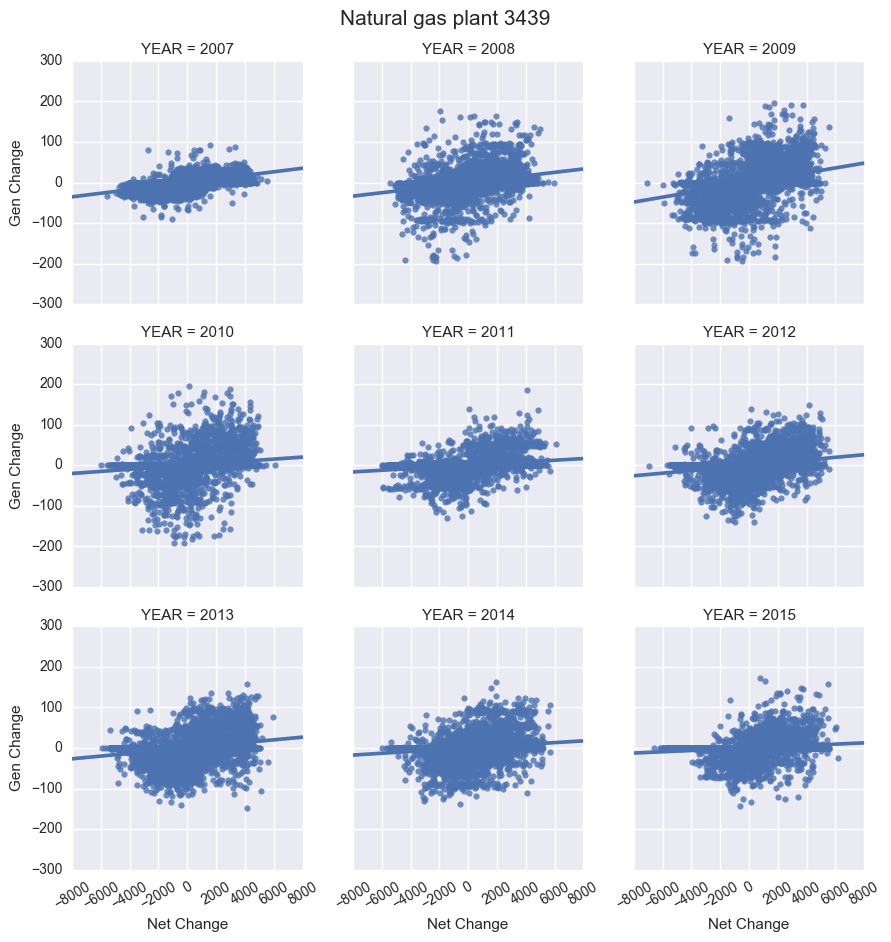

In [35]:
g = sns.FacetGrid(test[test['PLANT_ID']==3439], col='YEAR', col_wrap=3)
g.map(sns.regplot, 'Net Change', 'Gen Change')
g.set_xticklabels(rotation=30)
plt.suptitle('Natural gas plant 3439', y=1.02, size=15)